In [40]:
import tensorflow as tf

import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO


In [2]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [130]:
img1 = cv2.imread('./'  + 'train.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

img2 = cv2.imread('./'  + 'query.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

In [319]:
def delf_pipeline(image):
    np_image = np.array(image)
    float_image = tf.image.convert_image_dtype(np_image, tf.float32)
    
    return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(2000))

result1 = delf_pipeline(img1)
result2 = delf_pipeline(img2)

In [320]:
features1 = result1['features']
features2 = result2['features']

keypoints1 = result1['locations']
keypoints2 = result2['locations']

In [570]:
def key_points_matching_ckdtree(result1, result2):
    distance_threshold = 0.9

    num_features_1 = result1['locations'].shape[0]

    num_features_2 = result2['locations'].shape[0]

    d1_tree = cKDTree(result1['descriptors'])
    
    distance_ , indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)
    

    locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
      ])
    
    
    locations_1_to_use = np.array([
          result1['locations'][indices[i],]
          for i in range(num_features_2)
          if indices[i] != num_features_1
      ])
    
    _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)
    
    return inliers, locations_1_to_use, locations_2_to_use,distance_,indices


inliers,query_of_1_, query_of_2_,distance_,indices = key_points_matching_ckdtree(result1, result2)

inlier_idxs = np.nonzero(inliers)[0]

In [572]:
query_of_1 = np.float32([query_of_1_[i] for i in inlier_idxs])
query_of_2 = np.float32([query_of_2_[i] for i in inlier_idxs])

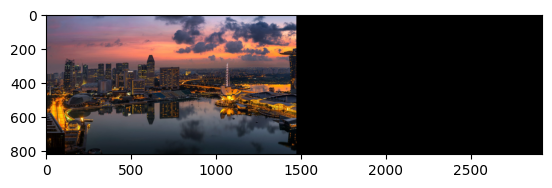

In [581]:
Homography_Matrix, _ = cv2.findHomography(query_of_1,query_of_2 , cv2.RANSAC)

result = cv2.warpPerspective(img1, Homography_Matrix, (img1.shape[1] + img2.shape[1], max(img2.shape[0], img1.shape[0])))

plt.imshow(result)

result[:img2.shape[0], :img2.shape[1]] = img2

plt.imshow(result)

plt.show()

Loaded image 1's 2000 features
Loaded image 2's 2000 features
Found 808 inliers


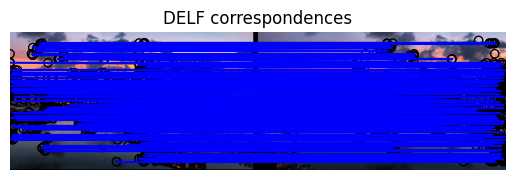

In [568]:
def match_images(image1, image2, result1, result2):
    distance_threshold = 0.6

    # Read features.
    num_features_1 = result1['locations'].shape[0]
    print("Loaded image 1's %d features" % num_features_1)

    num_features_2 = result2['locations'].shape[0]
    print("Loaded image 2's %d features" % num_features_2)

    # Find nearest-neighbor matches using a KD tree.
    d1_tree = cKDTree(result1['descriptors'])
    _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

    # Select feature locations for putative matches.
    locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
    ])

    # Perform geometric verification using RANSAC.
    _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

    print('Found %d inliers' % sum(inliers))

    # Visualize correspondences.
    _, ax = plt.subplots()
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    
    
match_images(img1, img2, result1, result2)